In [1]:
t_delta = 0.01

# Golden dynamics visualization

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

default_dir = os.path.dirname(os.getcwd())
os.chdir(default_dir)
import RLConn as rc
from RLConn import problem_definitions as problems
from RLConn import connectome_utils as connectome_utils

problem = problems.FOUR_NEURON_OSCILLATION
m1_target = problem.m1_target
m2_target = problem.m2_target

/home/stephen/anaconda3/envs/rlconn-env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/stephen/anaconda3/envs/rlconn-env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/stephen/anaconda3/envs/rlconn-env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/stephen/anaconda3/envs/rl




Instructions for updating:
Use keras.layers.dense instead.


/home/stephen/anaconda3/envs/rlconn-env/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/stephen/anaconda3/envs/rlconn-env/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/stephen/anaconda3/envs/rlconn-env/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/step

In [3]:
print("Shapes of m1 and m2: %s, %s" % (m1_target.shape, m2_target.shape))

Shapes of m1 and m2: (500,), (500,)


Text(0.5, 0.98, 'Golden dynamics')

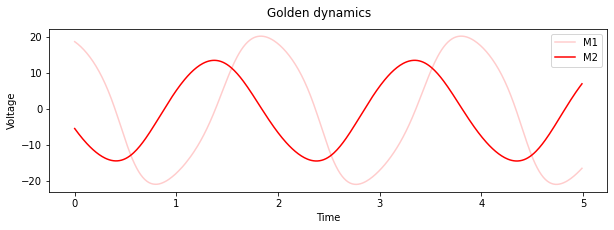

In [4]:
num_timesamples = m1_target.shape[0]

timepoints = np.arange(0, num_timesamples * t_delta, t_delta)
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(timepoints, m1_target, label="M1", c ="red", alpha =0.2)
ax.plot(timepoints, m2_target, label="M2", c ="red", alpha= 1.0)
ax.set_xlabel("Time")
ax.set_ylabel("Voltage")
ax.legend()
fig.suptitle("Golden dynamics")

# Initial unoptimized connectome

Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Mean error = 41.1595, Summed error  = 20579.7566


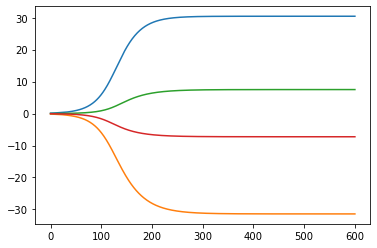

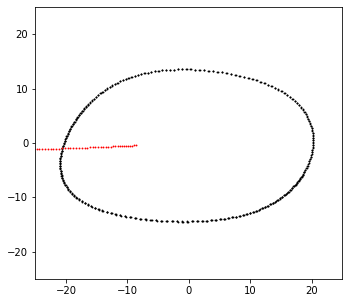

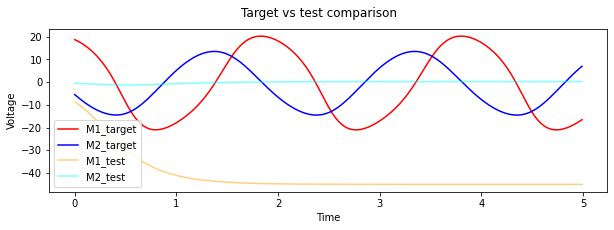

In [5]:
initial_network = connectome_utils.generate_random_network(
  N = problem.N,
  n_inhibitory = 1,
  max_degree = 15)
init_Gg = initial_network['gap']
init_Gs = initial_network['syn']

mean_err, summed_err = rc.utils.compute_problem_score(init_Gg, init_Gs,
                                                        problems.FOUR_NEURON_OSCILLATION, verbose=False)
print("Mean error = %.4f, Summed error  = %.4f" % (mean_err, summed_err))

# Perform optimization

In [8]:
from RLConn import stephen_utils as connectomes

eval_times = []
errs = []
num_called = 0
min_err = 1000000
def obj_fun(compact_vec):
  global num_called
  global min_err
  global init_Gg
  global init_Gs
  global eval_times
  global errors
  num_called += 1
  gg_mat, gs_mat = connectomes.compact_to_model_param(compact_vec, N)
  mean_err, summed_err = rc.utils.compute_problem_score(gg_mat, gs_mat, problem,
                                                        plot_result=False, verbose=False)
  # TODO: Train on summed_err or mean?
  err = summed_err
  min_err = min(min_err, err)
  if num_called % 10 == 0:
    print("Evaluation %s, error = %.2f, min_error = %.2f" % (num_called, err, min_err))
    print("Gg = " + str(gg_mat))
    print("Gs = " + str(gs_mat))
    print("delta Gg = " + str((init_Gg - gg_mat).round(2)))
    print("delta Gs = " + str((init_Gs - gs_mat).round(2)))
    eval_times.append(num_called)
    errs.append(err)
  return err

In [9]:
from scipy.optimize import minimize
from scipy.optimize import basinhopping
import time

N = problem.N
init_cond_compact = connectomes.model_to_compact_param(init_Gg, init_Gs, N)
bnds = [(0, 10)] * len(init_cond_compact)

"""
These methods are discarded:
Doesn't handle bounds. Documentation says: L-BFGS-B, TNC, SLSQP and trust-constr 
- BFGS 
- Powell 
- Nelder-Mead
"""

# See the options from here
# https://docs.scipy.org/doc/scipy-0.13.0/reference/generated/scipy.optimize.show_options.html
def optimize_with_SLSQP():
  return minimize(obj_fun, init_cond_compact, method='SLSQP', bounds=bnds,
                  options={'maxiter':100})

def optimize_with_L_BFGS_B():
  return minimize(obj_fun, init_cond_compact, method='L-BFGS-B', bounds=bnds,
                  options={'maxiter':10})

def optimize_with_TNC():
  return minimize(obj_fun, init_cond_compact, method='TNC', bounds=bnds,
                  options={'maxiter':10})

def optimize_with_trust_constr():
  return minimize(obj_fun, init_cond_compact, method='trust-constr', bounds=bnds,
                  options={'maxiter':100})

def optimize_with_basin_hopping():
  minimizer_kwargs = {"method":"Powell", "bounds":bnds}
  # You can add niter=k to limit the number of bruteforces
  return basinhopping(obj_fun, init_cond_compact, minimizer_kwargs=minimizer_kwargs)
  
start_time = time.time()
res = optimize_with_trust_constr()
print("Total optimization time = %.2fs" % (time.time() - start_time))
print(res)

Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameter

Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameter

Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameter

Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Evaluation 120, error = 20816.42, min_error = 20579.28
Gg = [[ 0.          2.98483966 12.00016802  3.00201295]
 [ 2.98483966  0.         11.00049306  7.9964468 ]
 [12.00016802 11.00049306  0.          9.99838035]
 [ 3.00201295  7.9964468   9.99838035  0.        ]]
Gs = [[0.00000000e+00 1.09997489e+01 1.19997638e+01 7.99919522e+00]
 [9.00068399e+00 0.00000000e+00 4.99764501e+00 3.25749389e-03]
 [2.83230850e-03 1.00375339e+00 0.00000000e+00 6.99888192e+00]
 [1.30000856e+01 1.20004467e+01 6.00234674e+00 0.00000000e+00]]
delta Gg = [[ 0.    0.02 -0.   -0.  ]
 [ 0.02  0.   -0.    0.  ]
 [-0.   -0.    0.    0.  ]
 [-0.    0.    0.    0.  ]]
delta Gs = [[ 0.  0.  0.  0.]
 [-0.  0.  0. -0.]
 [-0. -0.  0.  0.]
 [-0. -0. -0.  0.]]
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integra

Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Evaluation 160, error = 20593.93, 

Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameter

Evaluation 230, error = 20710.33, min_error = 20579.28
Gg = [[ 0.          2.99976719 12.00000467  3.00003345]
 [ 2.99976719  0.         10.99999644  7.99994291]
 [12.00000467 10.99999644  0.          9.99997622]
 [ 3.00003345  7.99994291  9.99997622  0.        ]]
Gs = [[0.00000000e+00 1.09999992e+01 1.19999980e+01 7.99999005e+00]
 [8.99999341e+00 0.00000000e+00 4.99996525e+00 5.48112281e-05]
 [4.69391146e-05 1.00005903e+00 0.00000000e+00 6.99998254e+00]
 [1.29999914e+01 1.19999968e+01 6.00003764e+00 0.00000000e+00]]
delta Gg = [[ 0.  0. -0. -0.]
 [ 0.  0.  0.  0.]
 [-0.  0.  0.  0.]
 [-0.  0.  0.  0.]]
delta Gs = [[ 0.  0.  0.  0.]
 [ 0.  0.  0. -0.]
 [-0. -0.  0.  0.]
 [ 0.  0. -0.  0.]]
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing

Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Evaluation 270, error = 20697.83, min_error = 20579.28
Gg = [[ 0.          2.99994081 12.00000114  3.00000813]
 [ 2.99994081  0.         11.0000019   7.99998599]
 [12.00000114 11.0000019   0.    

Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameter

Evaluation 340, error = 20579.16, min_error = 20574.21
Gg = [[ 0.          2.99998349 12.00000056  3.00000059]
 [ 2.99998349  0.         11.00000081  8.0000065 ]
 [12.00000056 11.00000081  0.         10.0000091 ]
 [ 3.00000059  8.0000065  10.0000091   0.        ]]
Gs = [[0.00000000e+00 1.09999999e+01 1.19999999e+01 7.99999901e+00]
 [9.00000105e+00 0.00000000e+00 4.99999693e+00 9.00277670e-07]
 [4.14100612e-07 9.99999681e-01 0.00000000e+00 6.99999849e+00]
 [1.30000003e+01 1.20000007e+01 6.00000195e+00 0.00000000e+00]]
delta Gg = [[ 0.  0. -0. -0.]
 [ 0.  0. -0. -0.]
 [-0. -0.  0. -0.]
 [-0. -0. -0.  0.]]
delta Gs = [[ 0.  0.  0.  0.]
 [-0.  0.  0. -0.]
 [-0.  0.  0.  0.]
 [-0. -0. -0.  0.]]
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing

Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Evaluation 380, error = 20580.66, min_error = 20574.21
Gg = [[ 0.          2.99998376 12.00000061  3.        ]
 [ 2.99998376  0.         11.0000003   8.0000068 ]
 [12.00000061 11.0000003   0.    

Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameter

Evaluation 450, error = 20579.00, min_error = 20574.21
Gg = [[ 0.          2.99998335 12.00000056  3.00000043]
 [ 2.99998335  0.         11.00000079  8.00000645]
 [12.00000056 11.00000079  0.         10.00000908]
 [ 3.00000043  8.00000645 10.00000908  0.        ]]
Gs = [[0.00000000e+00 1.09999999e+01 1.19999999e+01 7.99999897e+00]
 [9.00000103e+00 0.00000000e+00 4.99999677e+00 6.43054009e-07]
 [2.38778950e-07 9.99999442e-01 0.00000000e+00 6.99999844e+00]
 [1.30000003e+01 1.20000007e+01 6.00000197e+00 0.00000000e+00]]
delta Gg = [[ 0.  0. -0. -0.]
 [ 0.  0. -0. -0.]
 [-0. -0.  0. -0.]
 [-0. -0. -0.  0.]]
delta Gs = [[ 0.  0.  0.  0.]
 [-0.  0.  0. -0.]
 [-0.  0.  0.  0.]
 [-0. -0. -0.  0.]]
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing

Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Evaluation 490, error = 20578.53, min_error = 20574.21
Gg = [[ 0.          2.99998345 12.00000056  3.00000055]
 [ 2.99998345  0.         11.0000008   8.00000648]
 [12.00000056 11.0000008   0.    

Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameter

Evaluation 560, error = 20576.66, min_error = 20574.10
Gg = [[ 0.          2.99998349 12.00000056  3.00000059]
 [ 2.99998349  0.         11.00000081  8.00000649]
 [12.00000056 11.00000081  0.         10.0000091 ]
 [ 3.00000059  8.00000649 10.0000091   0.        ]]
Gs = [[0.00000000e+00 1.09999999e+01 1.19999999e+01 7.99999901e+00]
 [9.00000105e+00 0.00000000e+00 4.99999685e+00 8.96226748e-07]
 [4.26291166e-07 9.99999677e-01 0.00000000e+00 6.99999849e+00]
 [1.30000003e+01 1.20000007e+01 6.00000195e+00 0.00000000e+00]]
delta Gg = [[ 0.  0. -0. -0.]
 [ 0.  0. -0. -0.]
 [-0. -0.  0. -0.]
 [-0. -0. -0.  0.]]
delta Gs = [[ 0.  0.  0.  0.]
 [-0.  0.  0. -0.]
 [-0.  0.  0.  0.]
 [-0. -0. -0.  0.]]
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing

All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Evaluation 600, error = 20884.22, min_error = 20574.10
Gg = [[ 0.          2.89622968 12.01267223  3.00408165]
 [ 2.89622968  0.         10.96522432  8.03441361]
 [12.01267223 10.96522432  0.         10.03379935]
 [ 3.00408165  8.03441361 10.03379935  0.        ]]
Gs = [[0.00000000e+00 1.10010351e+01 1.20030912e+01 7.99340797e+00]
 [8.96061199e+00 0.00000000e+00 4.95256896e+00 1.56270314e-02]
 [1.09312691e-02 9.95582910e-

Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameter

Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameter

Evaluation 710, error = 20623.33, min_error = 20574.10
Gg = [[ 0.          2.99250408 12.00052056  3.0027161 ]
 [ 2.99250408  0.         10.99895542  8.00205516]
 [12.00052056 10.99895542  0.          9.99994493]
 [ 3.0027161   8.00205516  9.99994493  0.        ]]
Gs = [[ 0.00000000e+00  1.09990326e+01  1.20005690e+01  8.00124909e+00]
 [ 8.99916192e+00  0.00000000e+00  4.99790449e+00 -6.99587501e-04]
 [ 6.64183763e-05  1.00092512e+00  0.00000000e+00  7.00038963e+00]
 [ 1.29994106e+01  1.19997656e+01  6.00058807e+00  0.00000000e+00]]
delta Gg = [[ 0.    0.01 -0.   -0.  ]
 [ 0.01  0.    0.   -0.  ]
 [-0.    0.    0.    0.  ]
 [-0.   -0.    0.    0.  ]]
delta Gs = [[ 0.  0. -0. -0.]
 [ 0.  0.  0.  0.]
 [-0. -0.  0. -0.]
 [ 0.  0. -0.  0.]]
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy

Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameter

Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameter

Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameter

Evaluation 860, error = 20579.10, min_error = 20574.10
Gg = [[ 0.          2.99995764 12.00000191  3.00000635]
 [ 2.99995764  0.         10.99999659  8.00000553]
 [12.00000191 10.99999659  0.         10.00000759]
 [ 3.00000635  8.00000553 10.00000759  0.        ]]
Gs = [[ 0.00000000e+00  1.09999967e+01  1.19999976e+01  7.99999221e+00]
 [ 8.99999553e+00  0.00000000e+00  4.99998690e+00  1.77739403e-06]
 [-3.45383883e-06  1.00000666e+00  0.00000000e+00  6.99998794e+00]
 [ 1.29999976e+01  1.19999982e+01  5.99999738e+00  0.00000000e+00]]
delta Gg = [[ 0.  0. -0. -0.]
 [ 0.  0.  0. -0.]
 [-0.  0.  0. -0.]
 [-0. -0. -0.  0.]]
delta Gs = [[ 0.  0.  0.  0.]
 [ 0.  0.  0. -0.]
 [ 0. -0.  0.  0.]
 [ 0.  0.  0.  0.]]
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep comple

Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed

Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameter

Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameter

Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameter

Evaluation 1050, error = 20578.63, min_error = 20574.10
Gg = [[ 0.          2.99998348 12.00000056  3.00000063]
 [ 2.99998348  0.         11.0000008   8.00000649]
 [12.00000056 11.0000008   0.         10.0000091 ]
 [ 3.00000063  8.00000649 10.0000091   0.        ]]
Gs = [[0.00000000e+00 1.09999999e+01 1.19999999e+01 7.99999901e+00]
 [9.00000105e+00 0.00000000e+00 4.99999685e+00 8.84118257e-07]
 [4.03191535e-07 9.99999666e-01 0.00000000e+00 6.99999849e+00]
 [1.30000003e+01 1.20000007e+01 6.00000195e+00 0.00000000e+00]]
delta Gg = [[ 0.  0. -0. -0.]
 [ 0.  0. -0. -0.]
 [-0. -0.  0. -0.]
 [-0. -0. -0.  0.]]
delta Gs = [[ 0.  0.  0.  0.]
 [-0.  0.  0. -0.]
 [-0.  0.  0.  0.]
 [-0. -0. -0.  0.]]
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computin

Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Evaluation 1090, error = 20578.54, min_error = 20573.97
Gg = [[ 0.          2.99998349 12.00000056  3.00000059]
 [ 2.99998349  0.         11.00000081  8.00000649]
 [12.00000056 11.00000081  0.         10.00000925]
 [ 3.00000059  8.00000649 10.00000925  0.        ]]
Gs = [[0.00000000e+00 1.09999999e+01 1.19999999e+01 7.99999901e+00]
 [9.00000105e+00 0.000

Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameter

Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameter

Evaluation 1200, error = 25756.54, min_error = 20350.28
Gg = [[0.         2.76614013 9.99908206 2.23897423]
 [2.76614013 0.         9.99769358 4.68372945]
 [9.99908206 9.99769358 0.         9.99582628]
 [2.23897423 4.68372945 9.99582628 0.        ]]
Gs = [[0.         9.99743127 9.99915322 6.96677569]
 [9.99299851 0.         3.18125169 0.48417652]
 [0.41861401 1.93735978 0.         8.13384649]
 [9.99898281 9.99874151 4.07231404 0.        ]]
delta Gg = [[0.   0.23 2.   0.76]
 [0.23 0.   1.   3.32]
 [2.   1.   0.   0.  ]
 [0.76 3.32 0.   0.  ]]
delta Gs = [[ 0.    1.    2.    1.03]
 [-0.99  0.    1.82 -0.48]
 [-0.42 -0.94  0.   -1.13]
 [ 3.    2.    1.93  0.  ]]
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the 

Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Evaluation 1240, error = 25788.82, min_error = 20350.28
Gg = [[0.         2.76249053 9.99908192 2.23516726]
 [2.76249053 0.         9.99769298 4.68956195]
 [9.99908192 9.99769298 0.         9.99582623]
 [2.23516726 4.68956195 9.99582623 0.        ]]
Gs = [[0.         9.9974313  9.99915323 6.96984802]
 [9.99299295 0.         3.18006569 0.48475832]
 [0.42041833 1.93726374 0.         8.1344395 ]
 [9.99898286 9.99874131 4.07177577 0.        ]]
delta Gg = [[0.   0.24 2.   0.76]
 [0.24 0.   1.   3.31]
 [2.   1.   0.  

Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameter

Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameter

Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameter

Evaluation 1390, error = 25767.56, min_error = 20350.28
Gg = [[0.         2.76618274 9.99908206 2.23867977]
 [2.76618274 0.         9.99769358 4.68356924]
 [9.99908206 9.99769358 0.         9.99582627]
 [2.23867977 4.68356924 9.99582627 0.        ]]
Gs = [[0.         9.99743127 9.99915322 6.96662324]
 [9.99299852 0.         3.18223032 0.48420069]
 [0.41876806 1.93731683 0.         8.13348256]
 [9.99898281 9.99874151 4.07268071 0.        ]]
delta Gg = [[0.   0.23 2.   0.76]
 [0.23 0.   1.   3.32]
 [2.   1.   0.   0.  ]
 [0.76 3.32 0.   0.  ]]
delta Gs = [[ 0.    1.    2.    1.03]
 [-0.99  0.    1.82 -0.48]
 [-0.42 -0.94  0.   -1.13]
 [ 3.    2.    1.93  0.  ]]
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the 

Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Evaluation 1430, error = 25767.54, min_error = 20350.28
Gg = [[0.         2.76618298 9.99908192 2.23868031]
 [2.76618298 0.         9.99769358 4.68356953]
 [9.99908192 9.99769358 0.         9.995

Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameter

Evaluation 1500, error = 25768.42, min_error = 20350.28
Gg = [[0.         2.76627418 9.99908192 2.23889831]
 [2.76627418 0.         9.99769358 4.68360724]
 [9.99908192 9.99769358 0.         9.99582628]
 [2.23889831 4.68360724 9.99582628 0.        ]]
Gs = [[0.         9.99743127 9.99915322 6.96665263]
 [9.99299851 0.         3.18139731 0.48417339]
 [0.41862447 1.93737992 0.         8.13373298]
 [9.99898281 9.99874151 4.07225149 0.        ]]
delta Gg = [[0.   0.23 2.   0.76]
 [0.23 0.   1.   3.32]
 [2.   1.   0.   0.  ]
 [0.76 3.32 0.   0.  ]]
delta Gs = [[ 0.    1.    2.    1.03]
 [-0.99  0.    1.82 -0.48]
 [-0.42 -0.94  0.   -1.13]
 [ 3.    2.    1.93  0.  ]]
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the 

Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Evaluation 1540, error = 25769.67, min_error = 20350.28
Gg = [[0.         2.76627445 9.99908192 2.23891487]
 [2.76627445 0.         9.99769358 4.68361762]
 [9.99908192 9.99769358 0.         9.99582628]
 [2.23891487 4.68361762 9.99582628 0.        ]]
Gs = [[0.         9.99743127 9.99915322 6.96677839]
 [9.99299852 0.         3.1814054  0.48418372]
 [0.418

Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameter

Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameter

Evaluation 1650, error = 25756.87, min_error = 20350.28
Gg = [[0.         2.76625115 9.99908192 2.23889222]
 [2.76625115 0.         9.99769357 4.68360144]
 [9.99908192 9.99769357 0.         9.99582628]
 [2.23889222 4.68360144 9.99582628 0.        ]]
Gs = [[0.         9.99743127 9.99915322 6.96673354]
 [9.99299851 0.         3.18142761 0.48417269]
 [0.41864091 1.9373624  0.         8.13379828]
 [9.99898281 9.99874151 4.07224938 0.        ]]
delta Gg = [[0.   0.23 2.   0.76]
 [0.23 0.   1.   3.32]
 [2.   1.   0.   0.  ]
 [0.76 3.32 0.   0.  ]]
delta Gs = [[ 0.    1.    2.    1.03]
 [-0.99  0.    1.82 -0.48]
 [-0.42 -0.94  0.   -1.13]
 [ 3.    2.    1.93  0.  ]]
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the 

Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Evaluation 1690, error = 25758.09, min_error = 20350.28
Gg = [[0.         2.76626176 9.99908192 2.23891539]
 [2.76626176 0.         9.99769357 4.68362188]
 [9.99908192 9.99769357 0.         9.99582628]
 [2.23891539 4.68362188 9.99582628 0.        ]]
Gs = [[0.         9.99743127 9.99915322 6.96672345]
 [9.99299851 0.         3.18136894 0.48417137]
 [0.418

Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameter

Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameter

Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameter

Evaluation 1840, error = 25757.48, min_error = 20350.28
Gg = [[0.         2.76625378 9.99908192 2.238915  ]
 [2.76625378 0.         9.99769357 4.68363263]
 [9.99908192 9.99769357 0.         9.99582628]
 [2.238915   4.68363263 9.99582628 0.        ]]
Gs = [[0.         9.99743127 9.99915322 6.96672692]
 [9.99299851 0.         3.18137171 0.48417272]
 [0.4186285  1.93736904 0.         8.13380001]
 [9.99898281 9.99874151 4.07224047 0.        ]]
delta Gg = [[0.   0.23 2.   0.76]
 [0.23 0.   1.   3.32]
 [2.   1.   0.   0.  ]
 [0.76 3.32 0.   0.  ]]
delta Gs = [[ 0.    1.    2.    1.03]
 [-0.99  0.    1.82 -0.48]
 [-0.42 -0.94  0.   -1.13]
 [ 3.    2.    1.93  0.  ]]
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the 

Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Evaluation 1880, error = 25757.40, min_error = 20350.28
Gg = [[0.         2.76625494 9.99908192 2.23891415]
 [2.76625494 0.         9.99769357 4.68363302]
 [9.99908192 9.99769357 0.         9.99582628]
 [2.23891415 4.68363302 9.99582628 0.        ]]
Gs = [[0.         9.99743127 9.99915322 6.96672752]
 [9.99299851 0.         3.18137286 0.48417318]
 [0.418

Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameter

Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameter

Evaluation 1990, error = 25757.56, min_error = 20350.28
Gg = [[0.         2.76625513 9.99908192 2.23891383]
 [2.76625513 0.         9.99769357 4.68363316]
 [9.99908192 9.99769357 0.         9.99582628]
 [2.23891383 4.68363316 9.99582628 0.        ]]
Gs = [[0.         9.99743142 9.99915322 6.96672765]
 [9.99299851 0.         3.18137351 0.48417347]
 [0.41862863 1.93736913 0.         8.13379912]
 [9.99898281 9.99874151 4.07224073 0.        ]]
delta Gg = [[0.   0.23 2.   0.76]
 [0.23 0.   1.   3.32]
 [2.   1.   0.   0.  ]
 [0.76 3.32 0.   0.  ]]
delta Gs = [[ 0.    1.    2.    1.03]
 [-0.99  0.    1.82 -0.48]
 [-0.42 -0.94  0.   -1.13]
 [ 3.    2.    1.93  0.  ]]
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the 

Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Evaluation 2030, error = 25757.51, min_error = 20350.28
Gg = [[0.         2.76625531 9.99908192 2.23891369]
 [2.76625531 0.         9.99769357 4.68363317]
 [9.99908192 9.99769357 0.         9.99582628]
 [2.23891369 4.68363317 9.99582628 0.        ]]
Gs = [[0.         9.99743127 9.99915322 6.9667279 ]
 [9.99299851 0.         3.18137342 0.4841735 ]
 [0.418

Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameter

Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameter

Evaluation 2140, error = 25757.22, min_error = 20350.28
Gg = [[0.         2.76625548 9.99908192 2.23891371]
 [2.76625548 0.         9.99769357 4.68363319]
 [9.99908192 9.99769357 0.         9.99582628]
 [2.23891371 4.68363319 9.99582628 0.        ]]
Gs = [[0.         9.99743127 9.99915322 6.96672788]
 [9.99299851 0.         3.18137338 0.4841735 ]
 [0.41862876 1.93736906 0.         8.13379911]
 [9.99898281 9.99874166 4.07224084 0.        ]]
delta Gg = [[0.   0.23 2.   0.76]
 [0.23 0.   1.   3.32]
 [2.   1.   0.   0.  ]
 [0.76 3.32 0.   0.  ]]
delta Gs = [[ 0.    1.    2.    1.03]
 [-0.99  0.    1.82 -0.48]
 [-0.42 -0.94  0.   -1.13]
 [ 3.    2.    1.93  0.  ]]
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the 

Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Evaluation 2180, error = 25756.30, min_error = 20350.28
Gg = [[0.         2.76625549 9.99908192 2.23891372]
 [2.76625549 0.         9.99769357 4.68363318]
 [9.99908192 9.99769357 0.         9.99582628]
 [2.23891372 4.68363318 9.99582628 0.        ]]
Gs = [[0.         9.99743142 9.99915322 6.96672788]
 [9.99299851 0.         3.18137338 0.4841735 ]
 [0.418

Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameter

Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameter

Evaluation 2290, error = 25798.16, min_error = 20350.28
Gg = [[0.         2.76493226 9.99908191 2.23695546]
 [2.76493226 0.         9.99769357 4.67976607]
 [9.99908191 9.99769357 0.         9.99582623]
 [2.23695546 4.67976607 9.99582623 0.        ]]
Gs = [[0.         9.99743127 9.99915322 6.96757979]
 [9.99299846 0.         3.17735116 0.48426037]
 [0.41984937 1.93747902 0.         8.13313053]
 [9.99898281 9.99874152 4.06806685 0.        ]]
delta Gg = [[0.   0.24 2.   0.76]
 [0.24 0.   1.   3.32]
 [2.   1.   0.   0.  ]
 [0.76 3.32 0.   0.  ]]
delta Gs = [[ 0.    1.    2.    1.03]
 [-0.99  0.    1.82 -0.48]
 [-0.42 -0.94  0.   -1.13]
 [ 3.    2.    1.93  0.  ]]
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the 

Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Evaluation 2330, error = 25772.35, min_error = 20350.28
Gg = [[0.         2.76615992 9.99908192 2.23884077]
 [2.76615992 0.         9.99769358 4.68355356]
 [9.99908192 9.99769358 0.         9.99582628]
 [2.23884077 4.68355356 9.99582628 0.        ]]
Gs = [[0.         9.99743127 9.99915322 6.96672393]
 [9.99299851 0.         3.18124755 0.48418168]
 [0.418

Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameter

Evaluation 2400, error = 25771.60, min_error = 20350.28
Gg = [[0.         2.76616079 9.99908192 2.23884136]
 [2.76616079 0.         9.99769358 4.68355364]
 [9.99908192 9.99769358 0.         9.99582628]
 [2.23884136 4.68355364 9.99582628 0.        ]]
Gs = [[0.         9.99743127 9.99915322 6.96672427]
 [9.99299851 0.         3.18124859 0.48418154]
 [0.41864823 1.93724986 0.         8.13373469]
 [9.99898281 9.99874151 4.07232593 0.        ]]
delta Gg = [[0.   0.23 2.   0.76]
 [0.23 0.   1.   3.32]
 [2.   1.   0.   0.  ]
 [0.76 3.32 0.   0.  ]]
delta Gs = [[ 0.    1.    2.    1.03]
 [-0.99  0.    1.82 -0.48]
 [-0.42 -0.94  0.   -1.13]
 [ 3.    2.    1.93  0.  ]]
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the 

Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Evaluation 2440, error = 25760.93, min_error = 20350.28
Gg = [[0.         2.76621386 9.99908192 2.23888214]
 [2.76621386 0.         9.99769358 4.68358536]
 [9.99908192 9.99769358 0.         9.99582628]
 [2.23888214 4.68358536 9.99582628 0.        ]]
Gs = [[0.         9.99743127 9.99915322 6.96672126]
 [9.99299866 0.         3.18131017 0.48417714]
 [0.418

Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameter

The optimized Gg and Gs are:
[[0.         2.76625483 9.99908192 2.23891341]
 [2.76625483 0.         9.99769357 4.68362789]
 [9.99908192 9.99769357 0.         9.99582628]
 [2.23891341 4.68362789 9.99582628 0.        ]]
[[0.         9.99743127 9.99915322 6.96670193]
 [9.99299851 0.         3.18135842 0.48417535]
 [0.41863184 1.93737165 0.         8.13379358]
 [9.99898281 9.99874151 4.07224194 0.        ]]

Old Gg and Gs are:
[[ 0  3 12  3]
 [ 3  0 11  8]
 [12 11  0 10]
 [ 3  8 10  0]]
[[ 0 11 12  8]
 [ 9  0  5  0]
 [ 0  1  0  7]
 [13 12  6  0]]

The difference matrices are:
[[ 0.         -0.23374517 -2.00091808 -0.76108659]
 [-0.23374517  0.         -1.00230643 -3.31637211]
 [-2.00091808 -1.00230643  0.         -0.00417372]
 [-0.76108659 -3.31637211 -0.00417372  0.        ]]
[[ 0.         -1.00256873 -2.00084678 -1.03329807]
 [ 0.99299851  0.         -1.81864158  0.48417535]
 [ 0.41863184  0.93737165  0.          1.13379358]
 [-3.00101719 -2.00125849 -1.92775806  0.        ]]



Text(0.5, 0.98, 'Error trends during optimization')

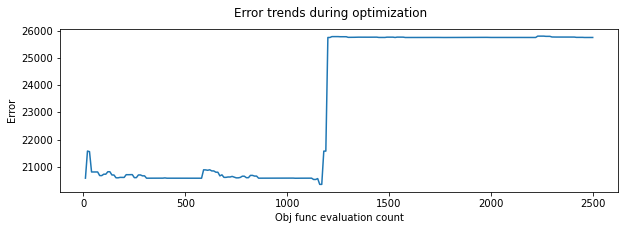

In [11]:
new_Gg, new_Gs = connectomes.compact_to_model_param(res.x, N)
print("The optimized Gg and Gs are:\n%s\n%s\n" % (new_Gg, new_Gs))
print("Old Gg and Gs are:\n%s\n%s\n" % (init_Gg, init_Gs))
print("The difference matrices are:\n%s\n%s\n" % (new_Gg-init_Gg, new_Gs-init_Gs))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
ax.plot(eval_times, errs)
ax.set_xlabel('Obj func evaluation count')
ax.set_ylabel('Error')
fig.suptitle("Error trends during optimization")

# Compare optimized dynamics against golden

Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Mean error = 17.8832, Summed error  = 8941.5766


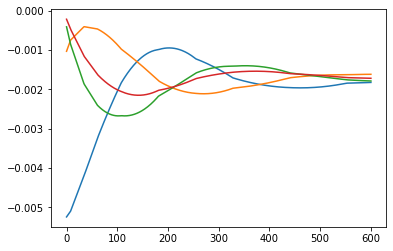

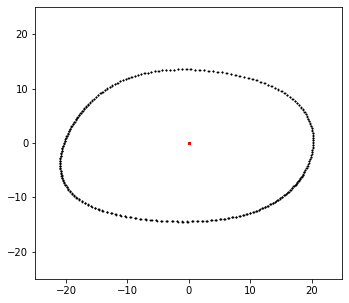

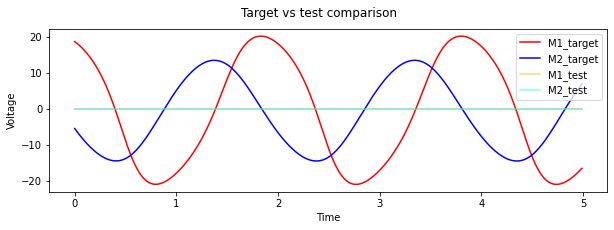

In [13]:
initial_network = connectome_utils.generate_random_network(
  N = problem.N,
  n_inhibitory = 1,
  max_degree = 15)

mean_err, summed_err = rc.utils.compute_problem_score(init_Gg, init_Gs,
                                                        problems.FOUR_NEURON_OSCILLATION, verbose=False)
print("Mean error = %.4f, Summed error  = %.4f" % (mean_err, summed_err))